# Handwritten Digit Classification with CNN + SVM (MNIST)

### Imports & Device Setup
- Import libraries for deep learning, SVM, data handling, and visualization.
- Set up device for GPU or CPU computation.
- Set random seeds for reproducibility.

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Using device: cuda


### Data Preparation & Loading
- Define image transformations and normalization for MNIST.
- Download and load MNIST training and test datasets.
- Create DataLoader objects and print dataset info.

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Get MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Dataset info
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in testing: {len(test_loader)}")


Training dataset size: 60000
Test dataset size: 10000
Number of batches in training: 938
Number of batches in testing: 157


### Visualize Training Images
- Display a grid of sample images from the training set.
- Show corresponding digit labels for each image.
- Verify data loading and preprocessing visually.

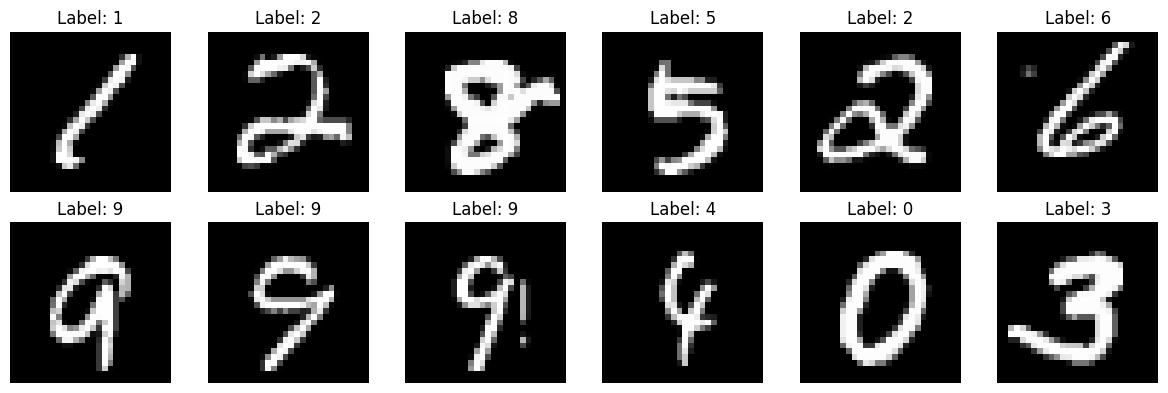

In [43]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


### Define the CNN Model
- Implement a convolutional neural network for digit classification.
- Add a method to extract features for SVM.
- Print the model architecture.

In [44]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc_block(x)
        return x

    def extract_flatten_features(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        return x

cnn_model = CNN().to(device)
print(cnn_model)


CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Loss Function & Optimizer
- Use cross-entropy loss for multi-class classification.
- Set up the Adam optimizer for CNN training.

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)


### Train the CNN Model
- Train the CNN for a specified number of epochs.
- Track and print training and test loss/accuracy per epoch.
- Measure and print total CNN training time.

In [46]:
num_epochs = 5
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

start_time_cnn_train = time.time()

for epoch in range(num_epochs):
    cnn_model.train()
    correct_train, total_train, running_train_loss = 0, 0, 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    cnn_model.eval()
    correct_test, total_test, running_test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_test_acc = 100 * correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

end_time_cnn_train = time.time()
cnn_training_time = end_time_cnn_train - start_time_cnn_train
print(f"\nCNN Training finished in {cnn_training_time:.2f} seconds.")

Epoch 1/5 [Train]: 100%|██████████| 938/938 [00:15<00:00, 60.07it/s]


Epoch 1/5 | Train Loss: 0.1427, Train Acc: 95.51% | Test Loss: 0.0510, Test Acc: 98.22%


Epoch 2/5 [Train]: 100%|██████████| 938/938 [00:15<00:00, 58.78it/s]


Epoch 2/5 | Train Loss: 0.0640, Train Acc: 97.95% | Test Loss: 0.0420, Test Acc: 98.75%


Epoch 3/5 [Train]: 100%|██████████| 938/938 [00:16<00:00, 57.64it/s]


Epoch 3/5 | Train Loss: 0.0476, Train Acc: 98.47% | Test Loss: 0.0328, Test Acc: 99.04%


Epoch 4/5 [Train]: 100%|██████████| 938/938 [00:15<00:00, 59.26it/s]


Epoch 4/5 | Train Loss: 0.0394, Train Acc: 98.78% | Test Loss: 0.0289, Test Acc: 99.07%


Epoch 5/5 [Train]: 100%|██████████| 938/938 [00:20<00:00, 45.67it/s]


Epoch 5/5 | Train Loss: 0.0363, Train Acc: 98.79% | Test Loss: 0.0257, Test Acc: 99.17%

CNN Training finished in 97.68 seconds.


### Evaluate CNN Model Performance
- Evaluate the trained CNN on the test set.
- Calculate and print final test accuracy.
- Store true and predicted labels for later analysis.

In [48]:
y_true_cnn, y_pred_cnn = [], []
cnn_model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true_cnn.extend(labels.cpu().numpy())
        y_pred_cnn.extend(predicted.cpu().numpy())

cnn_test_accuracy = 100 * correct / total
print(f"Final CNN Test Accuracy: {cnn_test_accuracy:.2f}%")


Final CNN Test Accuracy: 99.17%


### Plot CNN Training Curves
- Plot loss and accuracy curves for both training and test sets.
- Visualize model learning progress over epochs.

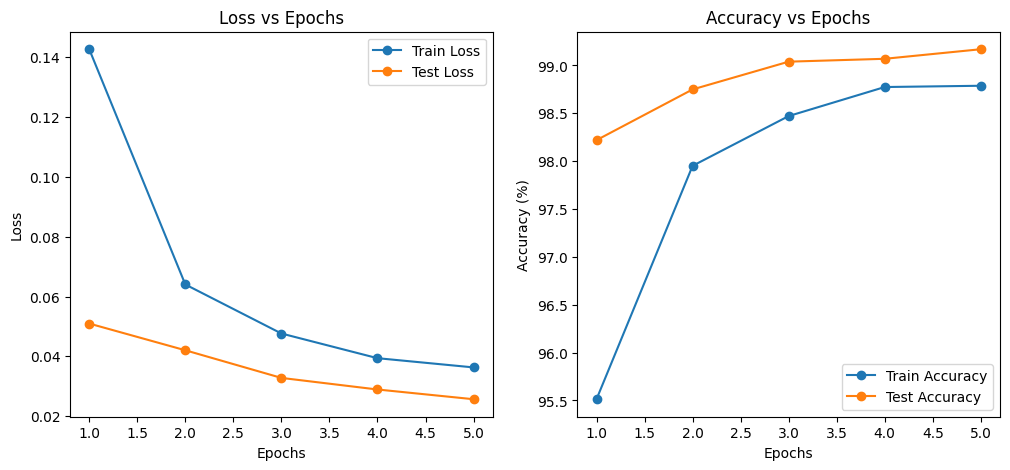

In [49]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.show()


### Show CNN Sample Predictions
- Visualize CNN predictions on test images.
- Highlight correct predictions in green and incorrect in red.
- Provide qualitative insight into CNN performance.

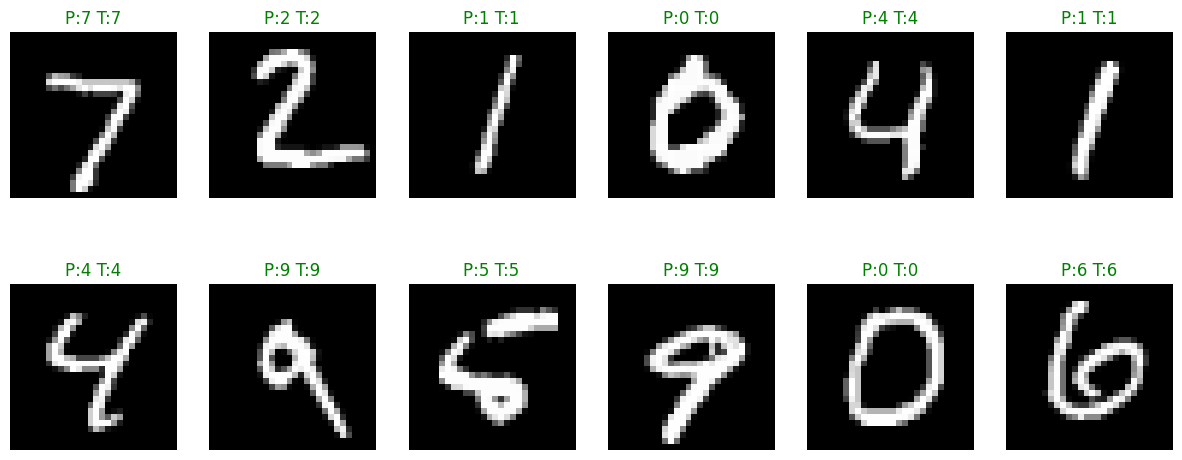

In [50]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

cnn_model.eval()
with torch.no_grad():
    output = cnn_model(example_data.to(device))
pred = output.argmax(dim=1, keepdim=True).cpu().numpy()

plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    color = 'green' if pred[i][0] == example_targets[i].item() else 'red'
    plt.title(f"P:{pred[i][0]} T:{example_targets[i].item()}", color=color)
    plt.axis('off')
plt.show()


### Extract Features with CNN for SVM
- Freeze CNN weights and extract features from images.
- Prepare feature vectors for SVM training and testing.
- Measure and print feature extraction time.

In [51]:
# Freeze CNN
for p in cnn_model.parameters():
    p.requires_grad = False
cnn_model.eval()

def extract_features(dataloader, feature_fn):
    feats, labs = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            f = feature_fn(images).cpu().numpy()
            feats.append(f)
            labs.append(labels.numpy())
    return np.concatenate(feats), np.concatenate(labs)

start_time_feature_extraction = time.time()

X_train_all, y_train_all = extract_features(train_loader, cnn_model.extract_flatten_features)
X_test, y_test = extract_features(test_loader, cnn_model.extract_flatten_features)

end_time_feature_extraction = time.time()
feature_extraction_time = end_time_feature_extraction - start_time_feature_extraction
print(f"Feature extraction finished in {feature_extraction_time:.2f} seconds.")

Extracting features: 100%|██████████| 157/157 [00:02<00:00, 71.75it/s]


Feature extraction finished in 16.91 seconds.


### Standardize Features
- Standardize extracted features using `StandardScaler`.
- Prepare features for SVM training and testing.

In [52]:
# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_all)
X_test_std = scaler.transform(X_test)

### Train SVM Classifier
- Subsample training data for faster SVM training.
- Train an RBF SVM on CNN-extracted features.
- Measure and print SVM training time.

In [53]:
# Subsample 15000 training samples for faster SVM training
subset_idx = np.random.choice(len(X_train_std), size=15000, replace=False)
X_train_sub, y_train_sub = X_train_std[subset_idx], y_train_all[subset_idx]

start_time_svm_train = time.time()

# Train RBF SVM
best_svm = SVC(C=1, gamma='scale', kernel='rbf')
best_svm.fit(X_train_sub, y_train_sub)

end_time_svm_train = time.time()
svm_training_time = end_time_svm_train - start_time_svm_train
print(f"SVM Training finished in {svm_training_time:.2f} seconds.")

SVM Training finished in 110.29 seconds.


### Evaluate SVM Classifier
- Predict digit labels on the test set using the trained SVM.
- Calculate and print SVM test accuracy.

In [54]:
svm_test_pred = best_svm.predict(X_test_std)
svm_test_acc = accuracy_score(y_test, svm_test_pred)*100
print(f"SVM Test Accuracy: {svm_test_acc:.2f}%")

SVM Test Accuracy: 98.03%


### Show SVM Sample Predictions
- Visualize SVM predictions on test images.
- Highlight correct predictions in green and incorrect in red.
- Provide qualitative insight into SVM performance.

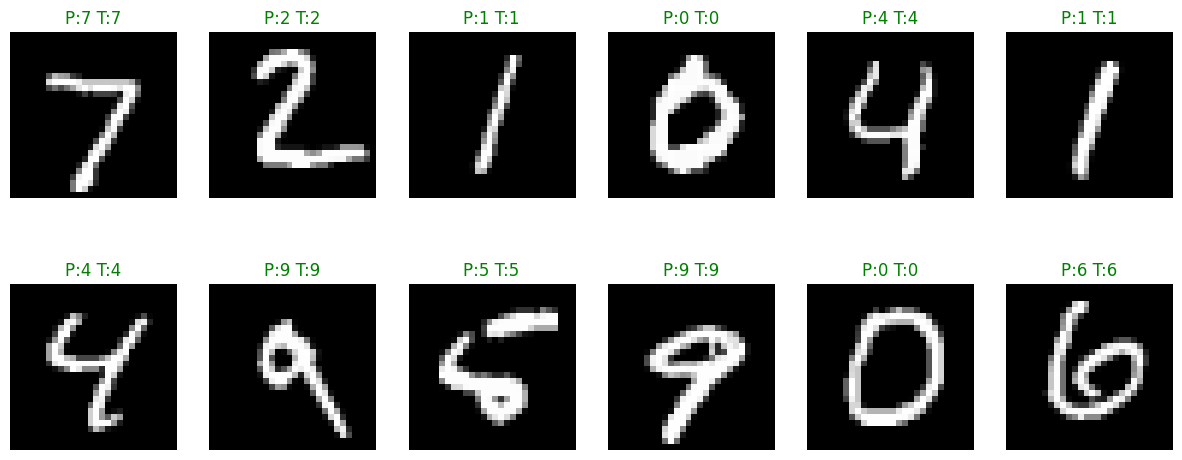

In [55]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

cnn_model.eval()
with torch.no_grad():
    features = cnn_model.extract_flatten_features(example_data.to(device)).cpu().numpy()

features_std = scaler.transform(features)
svm_pred = best_svm.predict(features_std)

plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    color = 'green' if svm_pred[i] == example_targets[i].item() else 'red'
    plt.title(f"P:{svm_pred[i]} T:{example_targets[i].item()}", color=color)
    plt.axis('off')
plt.show()


### Print Classification Reports
- Print detailed classification reports for both CNN and CNN+SVM models.
- Show precision, recall, and F1-score for each class.

In [56]:
print("          CNN Performance Report")
print(classification_report(y_true_cnn, y_pred_cnn, digits=4))
print("        CNN+SVM Performance Report")
print(classification_report(y_test, svm_test_pred, digits=4))

          CNN Performance Report
              precision    recall  f1-score   support

           0     0.9888    0.9949    0.9919       980
           1     0.9930    0.9974    0.9952      1135
           2     0.9932    0.9922    0.9927      1032
           3     0.9911    0.9970    0.9941      1010
           4     0.9869    0.9959    0.9914       982
           5     0.9966    0.9877    0.9921       892
           6     0.9937    0.9885    0.9911       958
           7     0.9903    0.9903    0.9903      1028
           8     0.9898    0.9959    0.9928       974
           9     0.9939    0.9762    0.9850      1009

    accuracy                         0.9917     10000
   macro avg     0.9917    0.9916    0.9917     10000
weighted avg     0.9917    0.9917    0.9917     10000

        CNN+SVM Performance Report
              precision    recall  f1-score   support

           0     0.9928    0.9786    0.9856       980
           1     0.9886    0.9930    0.9908      1135
          

### Compare Model Performance
- Compare accuracy, precision, recall, and F1-score for CNN and CNN+SVM.
- Visualize metrics in a bar chart for easy comparison.

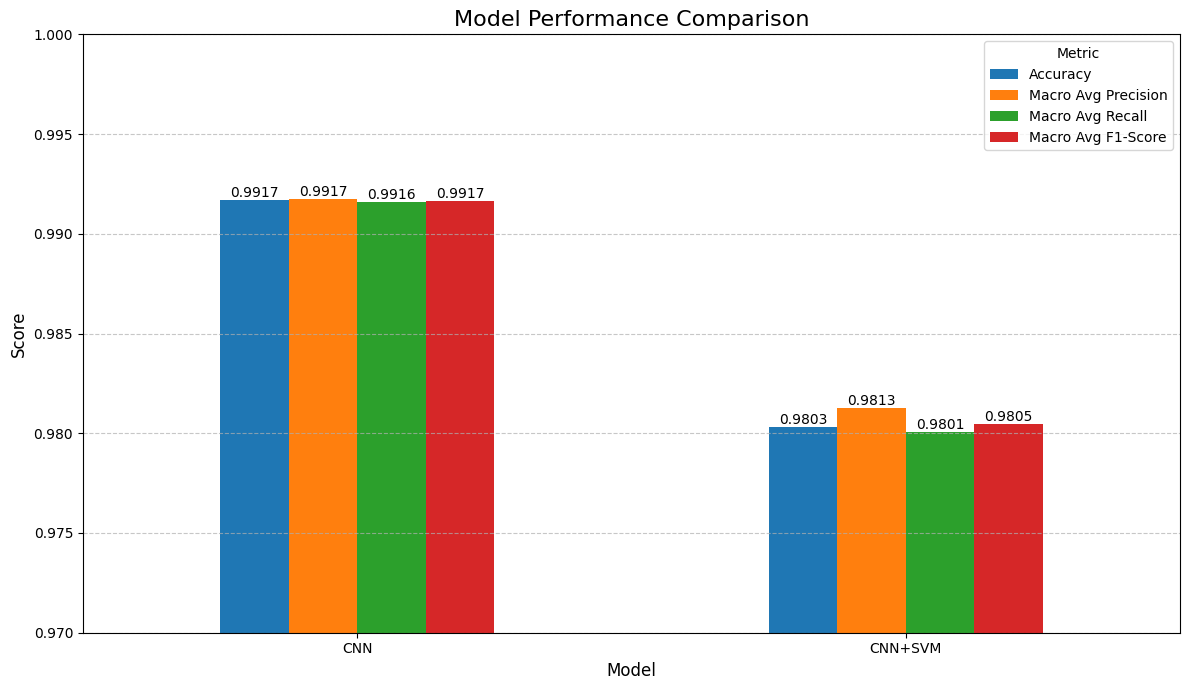

In [57]:
cnn_report = classification_report(y_true_cnn, y_pred_cnn, output_dict=True)
svm_report = classification_report(y_test, svm_test_pred, output_dict=True)

performance_data = {
    'Model': ['CNN', 'CNN+SVM'],
    'Accuracy': [cnn_test_accuracy / 100, svm_test_acc / 100],
    'Macro Avg Precision': [cnn_report['macro avg']['precision'], svm_report['macro avg']['precision']],
    'Macro Avg Recall': [cnn_report['macro avg']['recall'], svm_report['macro avg']['recall']],
    'Macro Avg F1-Score': [cnn_report['macro avg']['f1-score'], svm_report['macro avg']['f1-score']]
}
performance_df = pd.DataFrame(performance_data).set_index('Model')

# Plot Performance Metrics
fig, ax = plt.subplots(figsize=(12, 7))
performance_df.plot(kind='bar', ax=ax)

# Formatting
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_ylim([0.97, 1.0])

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.legend(title='Metric')
plt.tight_layout()
plt.show()

### Confusion Matrices
- Display confusion matrices for both CNN and CNN+SVM predictions.
- Visualize misclassifications and per-class performance.

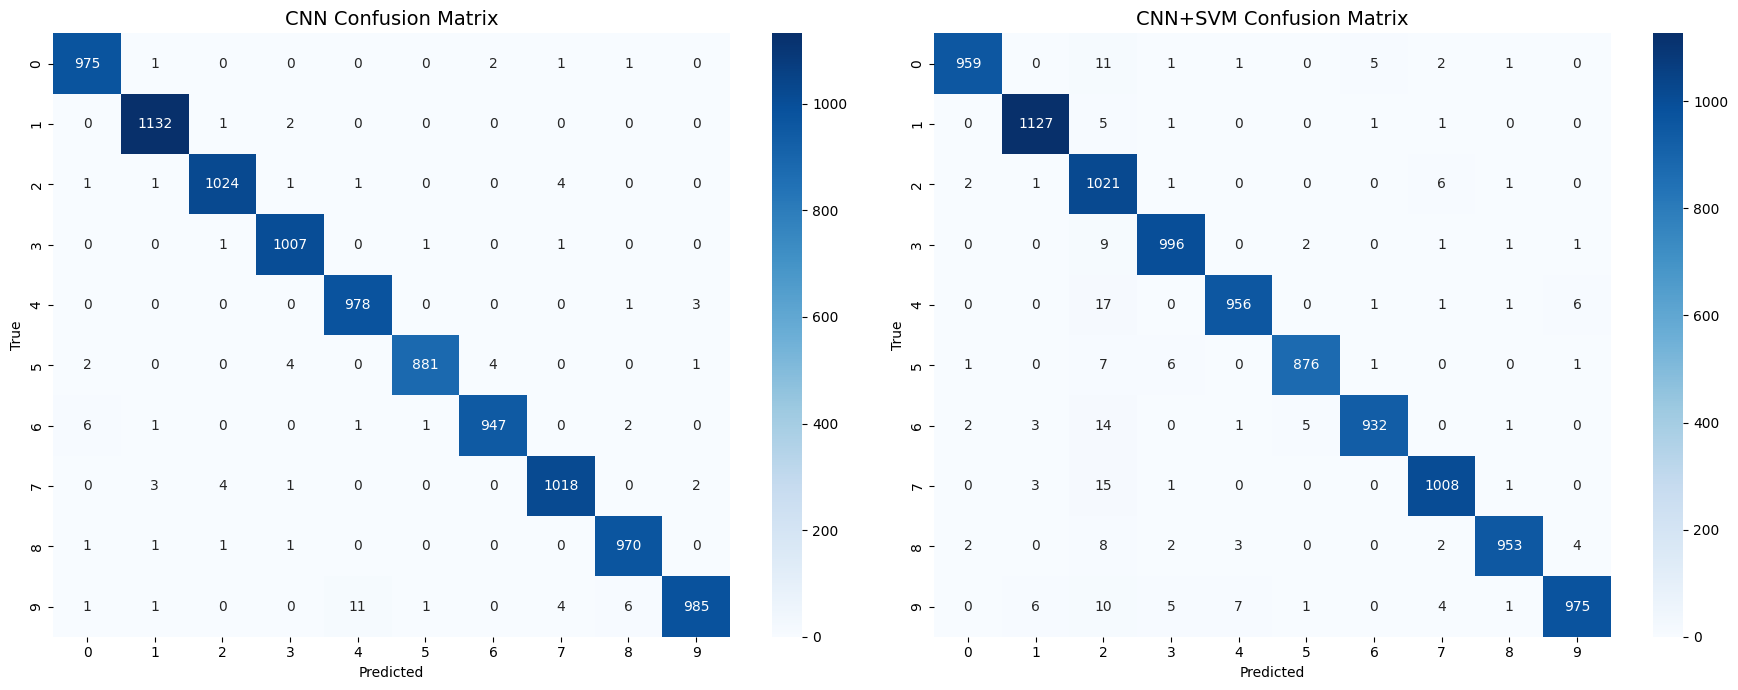

In [58]:
# Create confusion matrices
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
cm_svm = confusion_matrix(y_test, svm_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CNN Confusion Matrix
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("CNN Confusion Matrix", fontsize=14)

# CNN+SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("CNN+SVM Confusion Matrix", fontsize=14)

plt.tight_layout()
plt.show()

### Efficiency Metrics Summary
- Compare training times for CNN and CNN+SVM (feature extraction + SVM fit).
- Print a summary table of efficiency metrics.

In [59]:
# Efficiency Summary
hybrid_training_time = feature_extraction_time + svm_training_time
efficiency_data = {
    'Model': ['CNN', 'CNN+SVM (Feature Extraction + SVM fit)'],
    'Training Time (s)': [cnn_training_time, hybrid_training_time]
}
efficiency_df = pd.DataFrame(efficiency_data).set_index('Model')

print("         Efficiency Metrics Summary")
print(efficiency_df.round(2))


         Efficiency Metrics Summary
                                        Training Time (s)
Model                                                    
CNN                                                 97.68
CNN+SVM (Feature Extraction + SVM fit)             127.20
